The aim of this notebook is to understand how and where can code benefit from multithreading and optimize parameters

PREPARATION

Importing neccessary libraries

In [1]:
import os
import sys
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

Setting up path to work with getelec. NOTE: pythonpath needs updating to work on other pcs

In [2]:
mainpath,filename = os.path.split(os.path.dirname(os.getcwd()))

emissionpath,mainfolder = os.path.split(mainpath)
emissionpath,mainfolder = os.path.split(emissionpath)

pythonpath = emissionpath + '/mikael/GETELEC/interfaces/web_interface'
sys.path.append(pythonpath)

In [3]:
pythonpath

'/home/mikael/GETELEC/interfaces/web_interface'

Importing base functions from getelec module

In [4]:
from getelec_online import current_metal_emitter, heat_metal_emitter, spectrum_metal_emitter
from getelec_online import current_metal_emitter_threaded

It can be seen that on first import of the functions, 'tabulation' folder is created.
In this folder, tables are saved.

In [5]:
def generate_debug_metal_values(number_of_points, low_field = 1, max_field = 10, radius = 50, gamma = 10, work_function = 4.5, temperature = 300 ):

    _field = np.linspace(low_field, max_field, number_of_points)
    _radius = np.full(number_of_points, radius)
    _gamma = np.full(number_of_points, gamma)
    _work_function = np.full(number_of_points, work_function)
    _temperature = np.full(number_of_points, temperature)

    return (_field, _radius, _gamma, _work_function, _temperature)


In [6]:
field, radius, gamma, work_function, temperature = generate_debug_metal_values(32)

Let's see how field looks like

In [7]:
print('Field: ', field)

Field:  [ 1.          1.29032258  1.58064516  1.87096774  2.16129032  2.4516129
  2.74193548  3.03225806  3.32258065  3.61290323  3.90322581  4.19354839
  4.48387097  4.77419355  5.06451613  5.35483871  5.64516129  5.93548387
  6.22580645  6.51612903  6.80645161  7.09677419  7.38709677  7.67741935
  7.96774194  8.25806452  8.5483871   8.83870968  9.12903226  9.41935484
  9.70967742 10.        ]


METRICS


Making sure functions have the same output

In [8]:
current_original = current_metal_emitter(field, radius, gamma, work_function, temperature)
current_beta = current_metal_emitter_threaded(field, radius, gamma, work_function, temperature)

def percentage_difference(array1, array2):
    return np.sum(100 * (array1 - array2) / array1)

print("Percentage Difference:", percentage_difference(current_beta, current_original), '%')

Percentage Difference: 0.0 %


Writing logic for loop

In [9]:
def cycle(start_epoch, threads):

    field_long, radius_long, gamma_long, work_function_long, temperature_long = generate_debug_metal_values(start_epoch)

    start_time = time.time()
    current_metal_emitter(field_long, radius_long, gamma_long, work_function_long, temperature_long)
    end_time = time.time()
    time_difference_1 = end_time - start_time

    start_time = time.time()
    current_metal_emitter_threaded(field_long, radius_long, gamma_long, work_function_long, temperature_long, threads)
    end_time = time.time()
    time_difference_2 = end_time - start_time

    total_time_difference = time_difference_2 - time_difference_1

    return total_time_difference

def basic_time_measurement(start_epoch, max_epoch, threads, step_size = 1):

    time_differences = np.array([])

    while start_epoch < max_epoch:

        time_differences = np.append(time_differences, cycle(start_epoch, threads))

        #if start_epoch % 100 == 0: print(f"Running epoch ${start_epoch}")

        start_epoch = start_epoch + step_size

    return time_differences


Code for visualization of results

In [10]:
def plot_with_average(start, finish, basic_times, step_size):
    x = np.arange(start, finish, step_size)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, basic_times)

    plt.figure(figsize=(20, 6))
    plt.title(f'Number of threads: {i}, optimal size from: { int(-intercept / slope) }')
    plt.xlabel('Point count, n')
    plt.ylabel('Time, s')
    plt.plot(x, basic_times, label='Times')
    plt.plot(x, intercept + slope * x, label='Fitted line')
    plt.legend()
    plt.show()

    return (-intercept / slope) / i

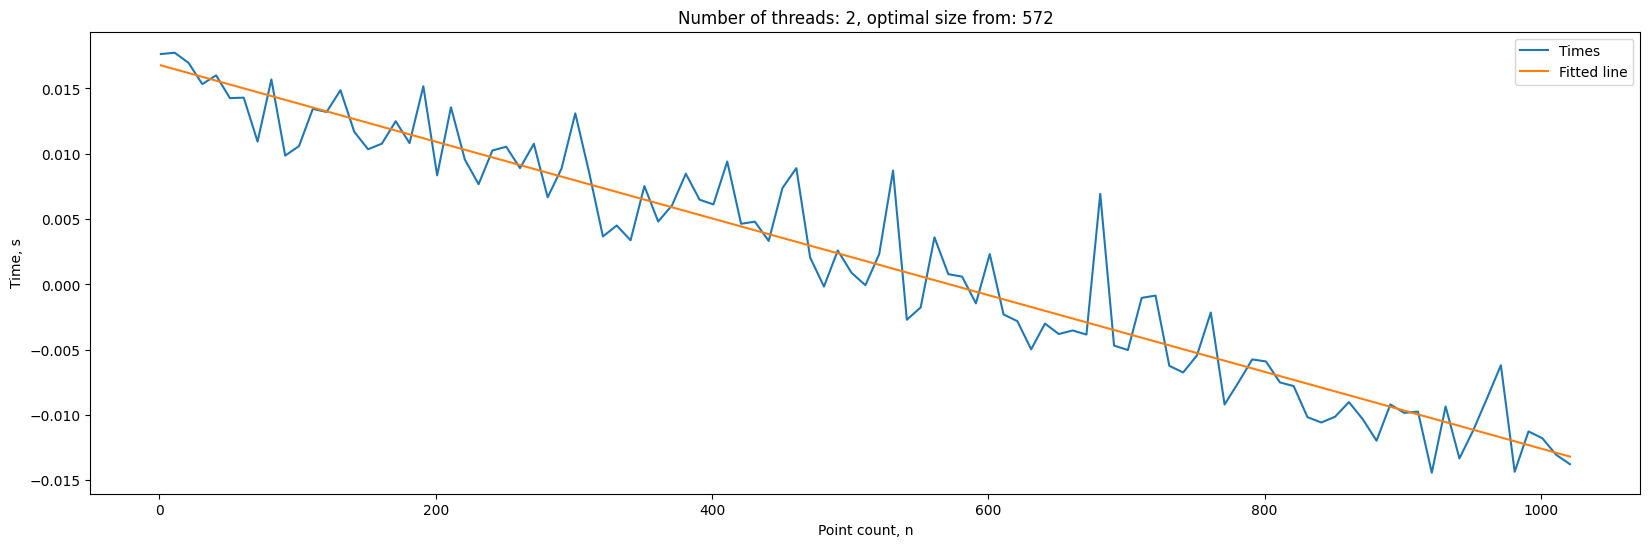

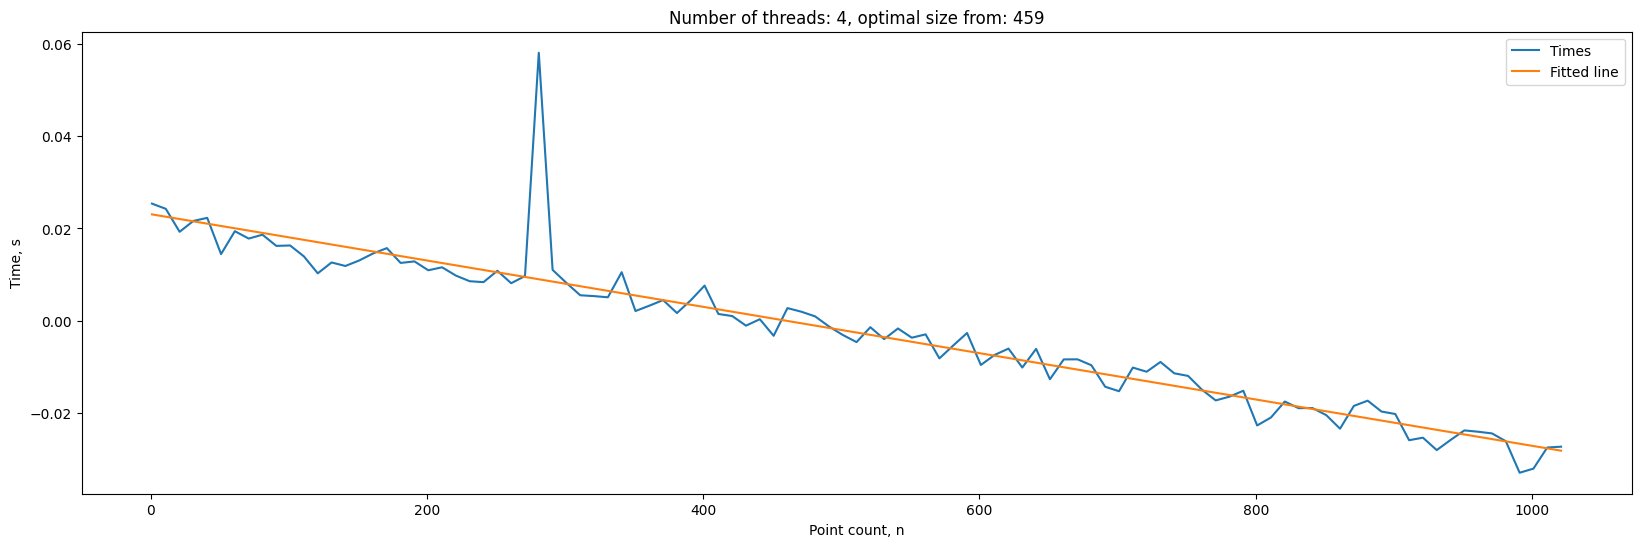

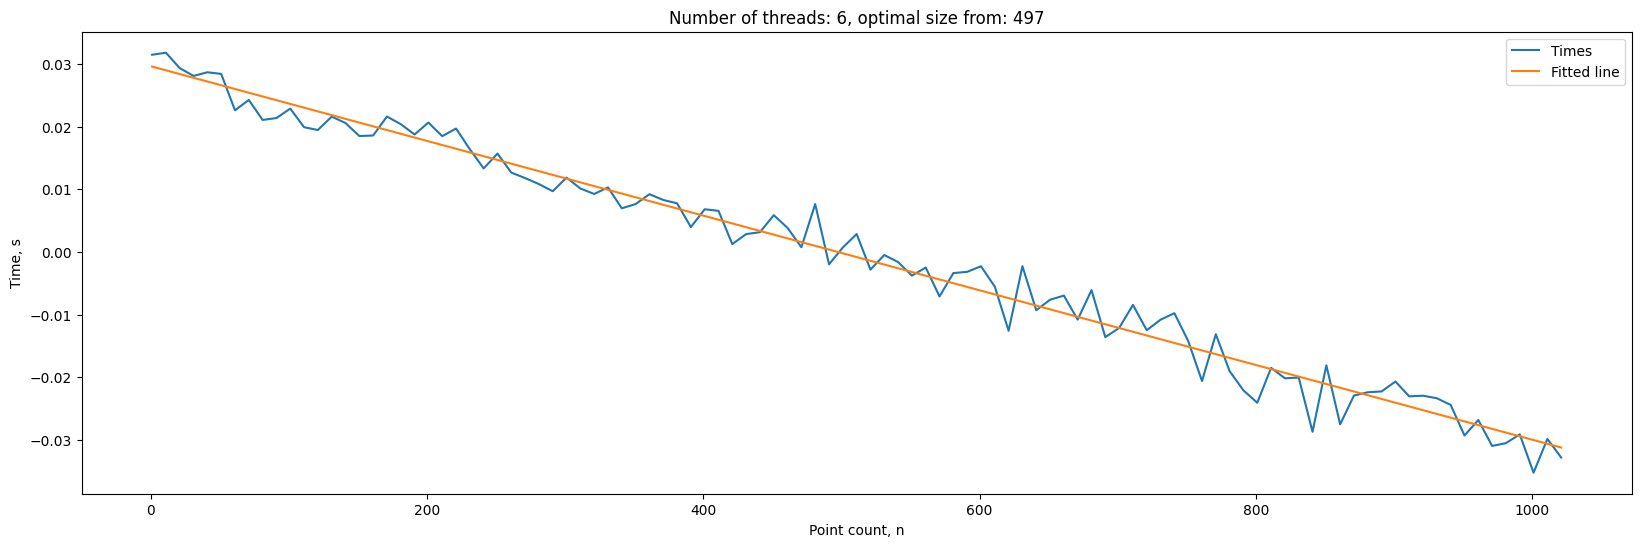

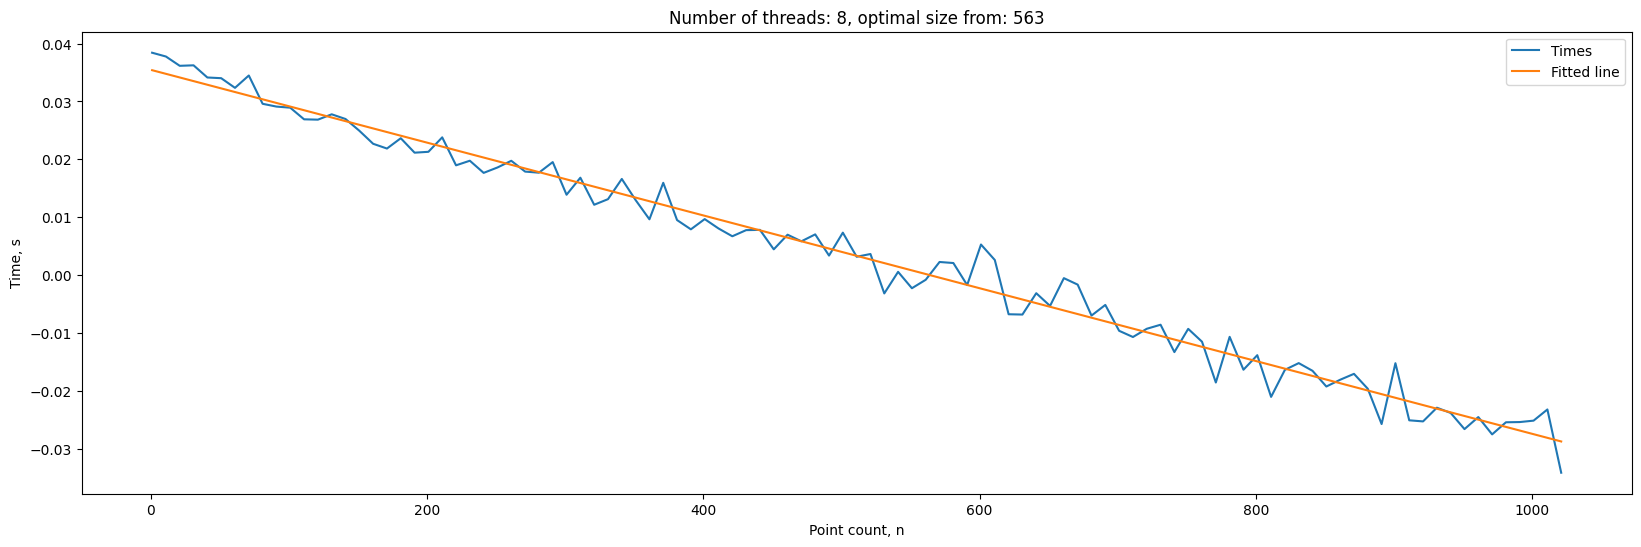

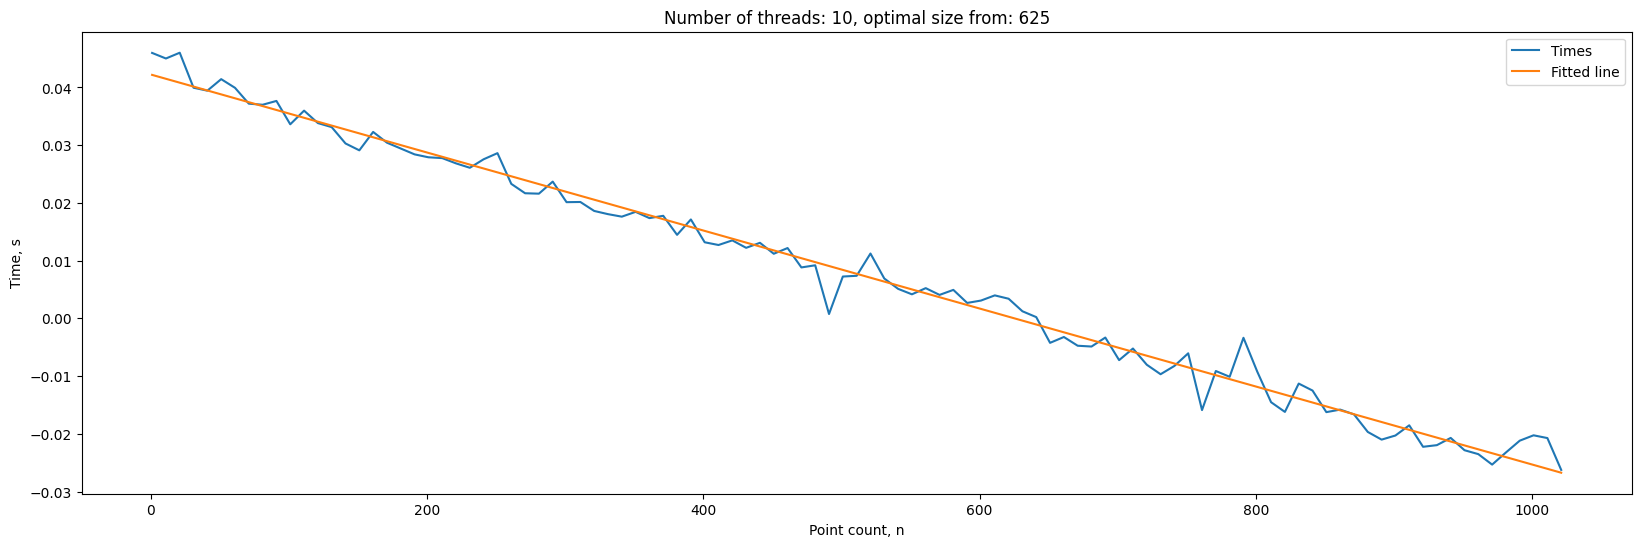

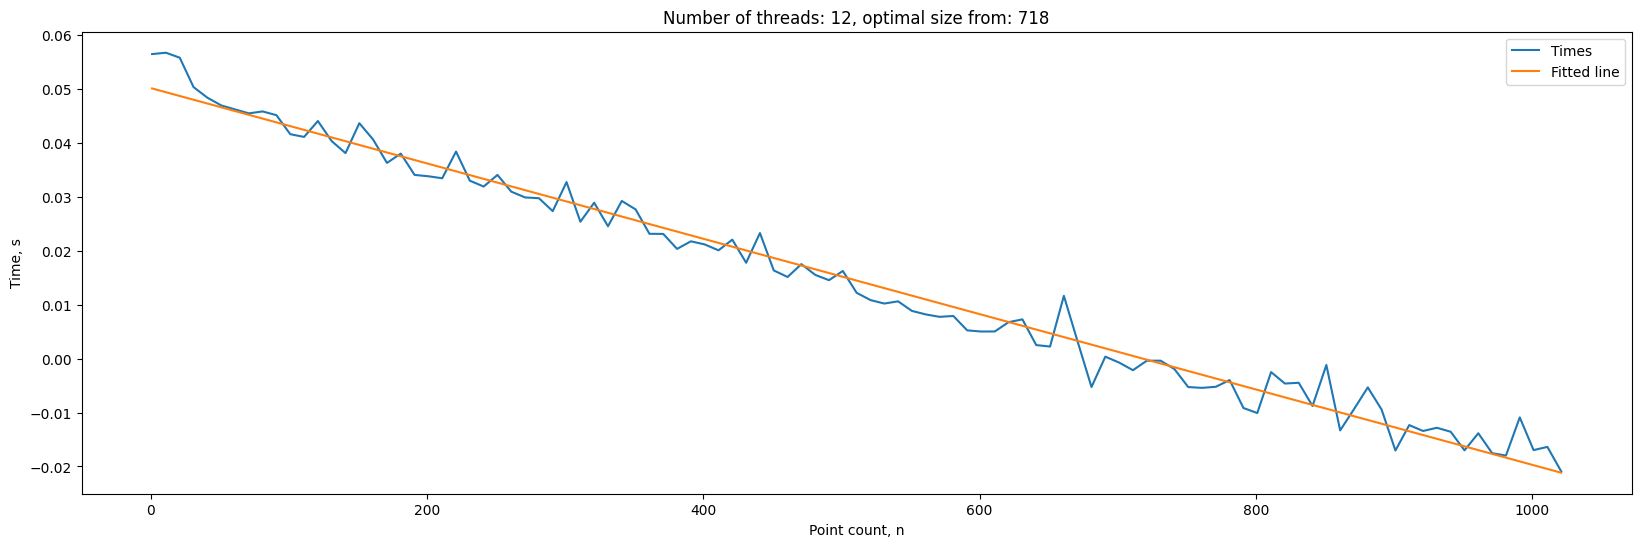

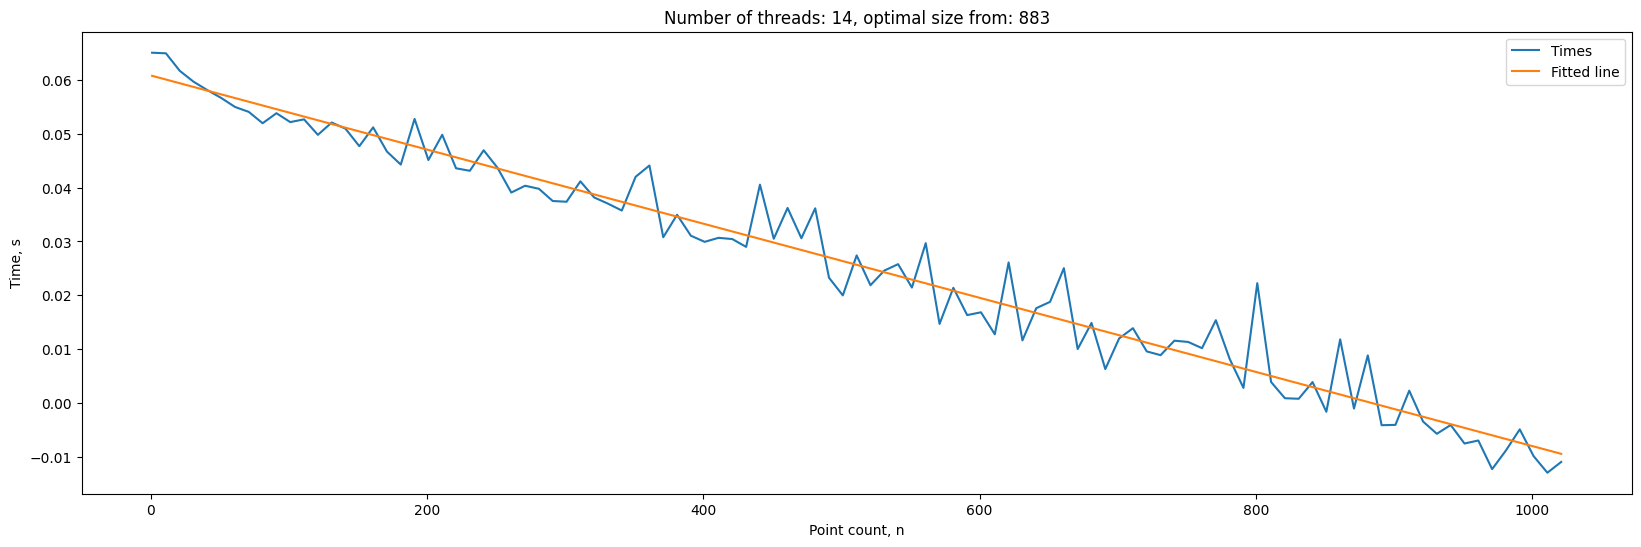

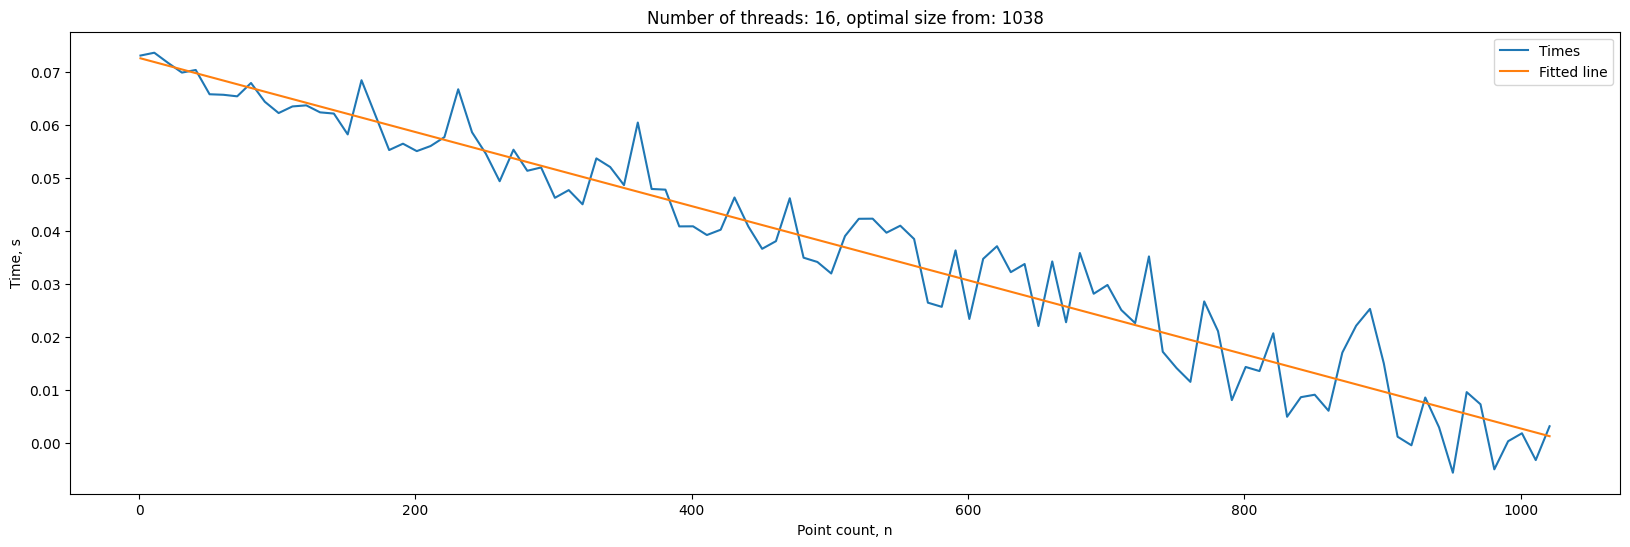

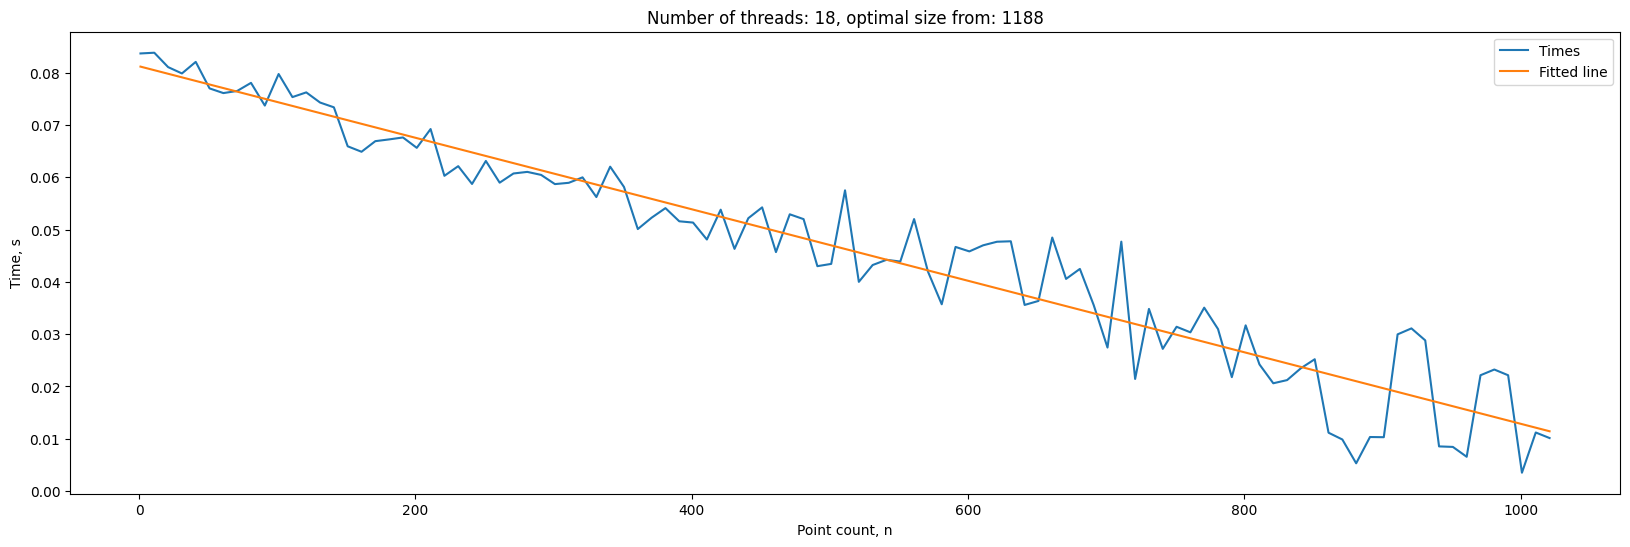

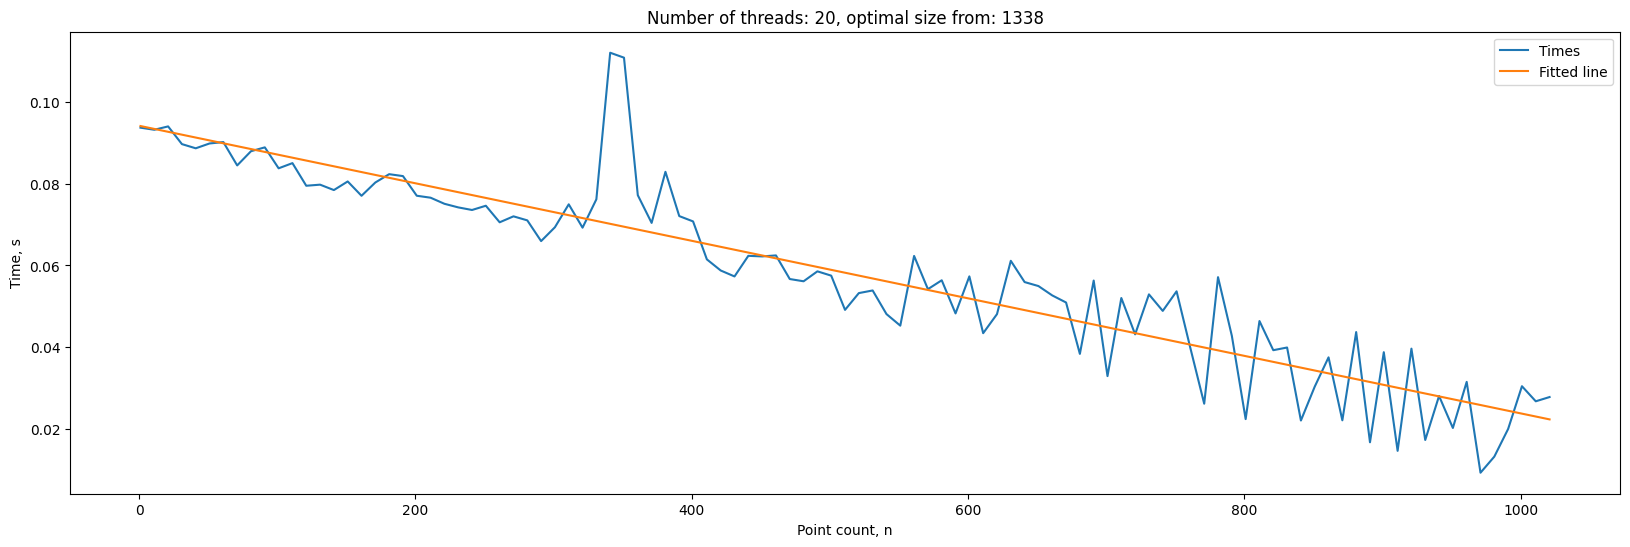

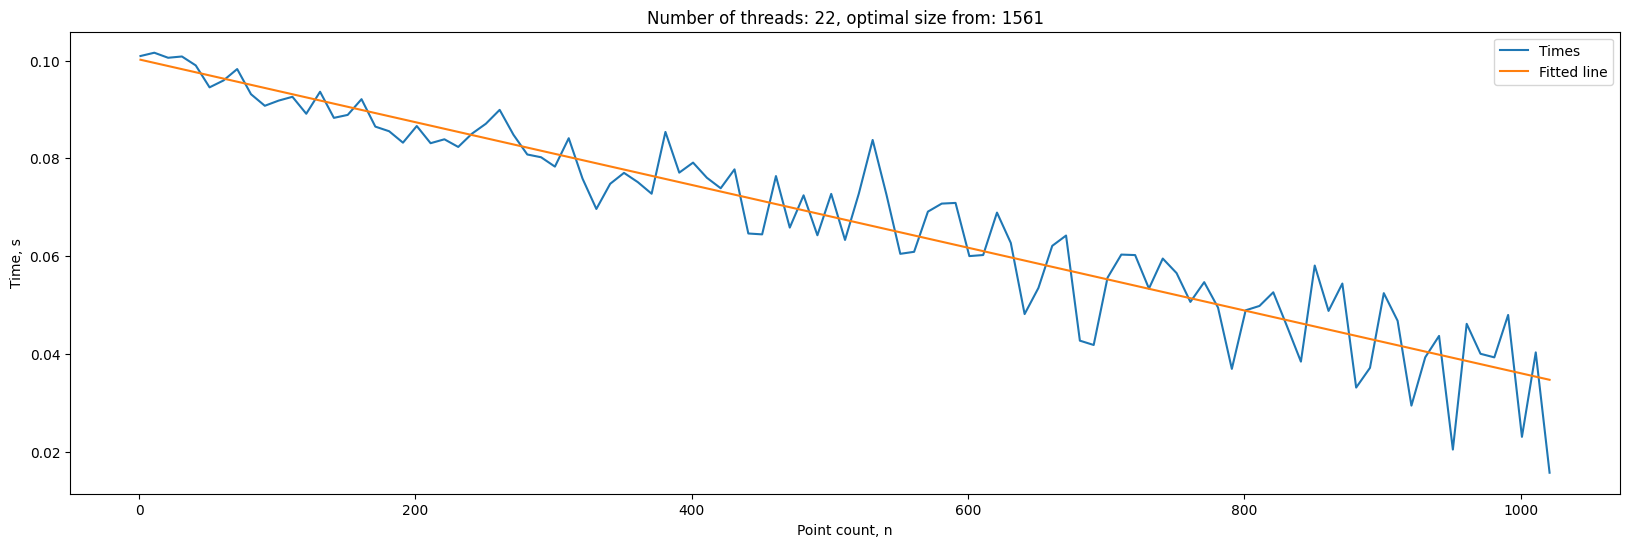

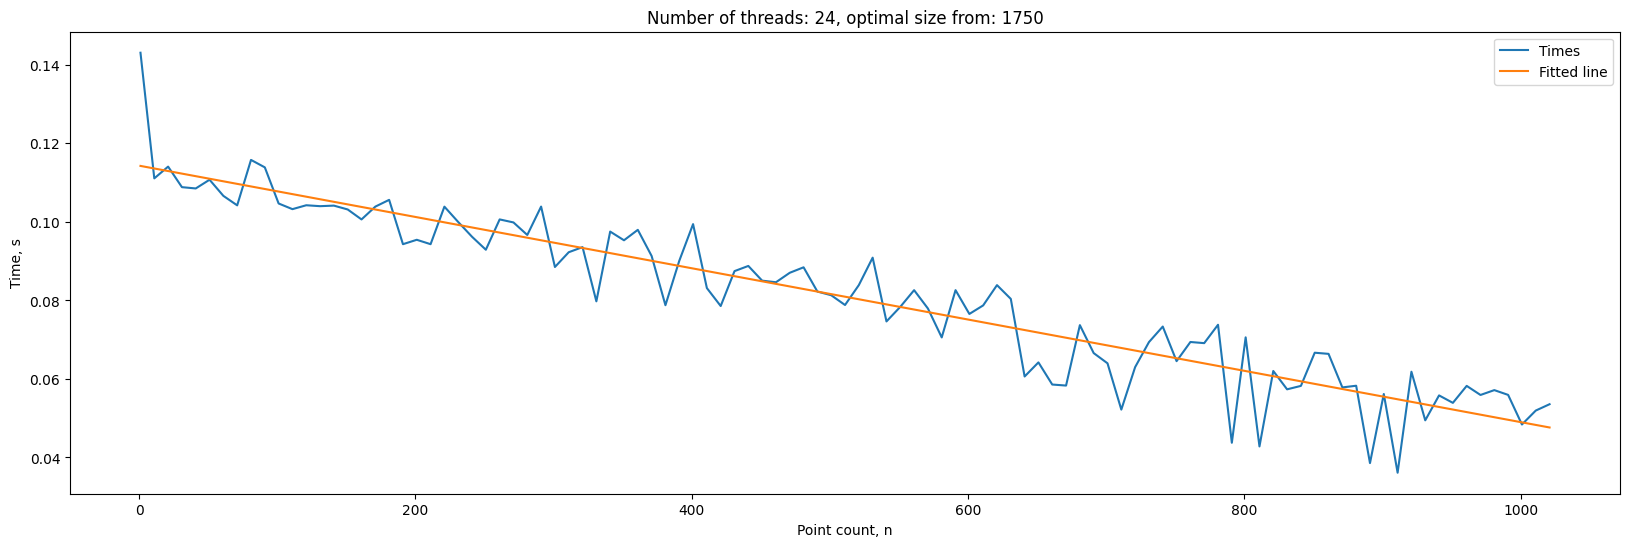

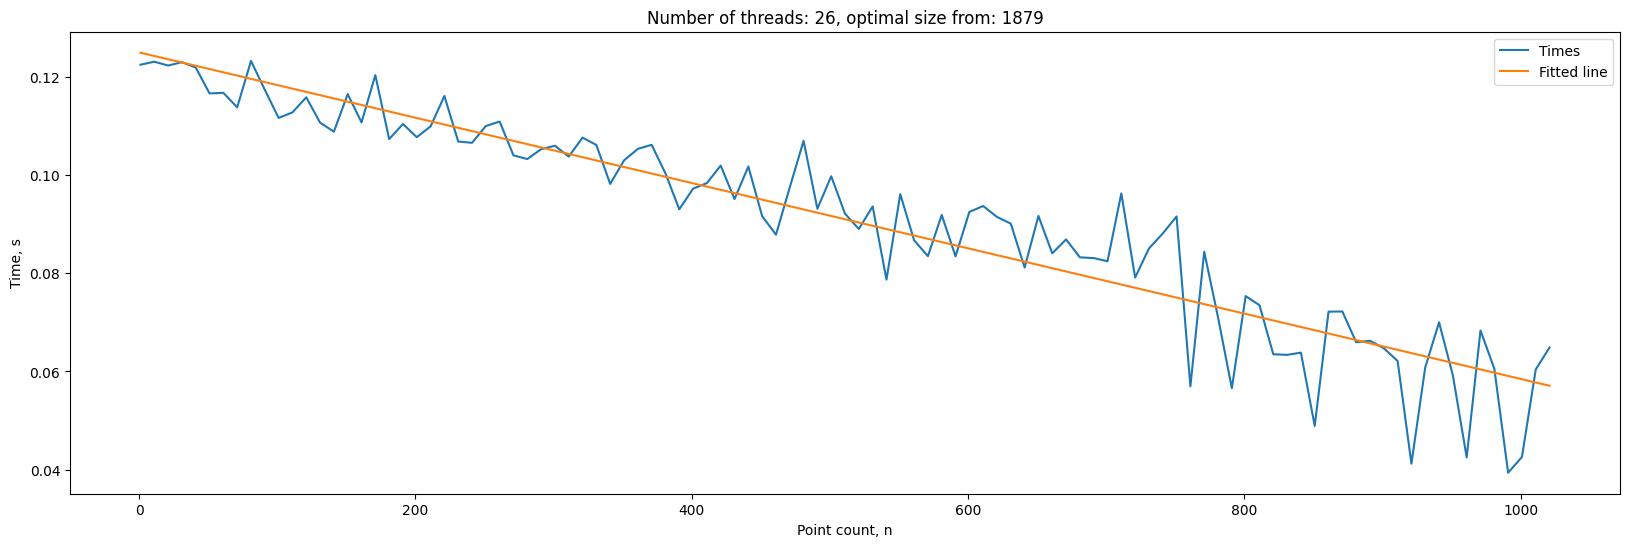

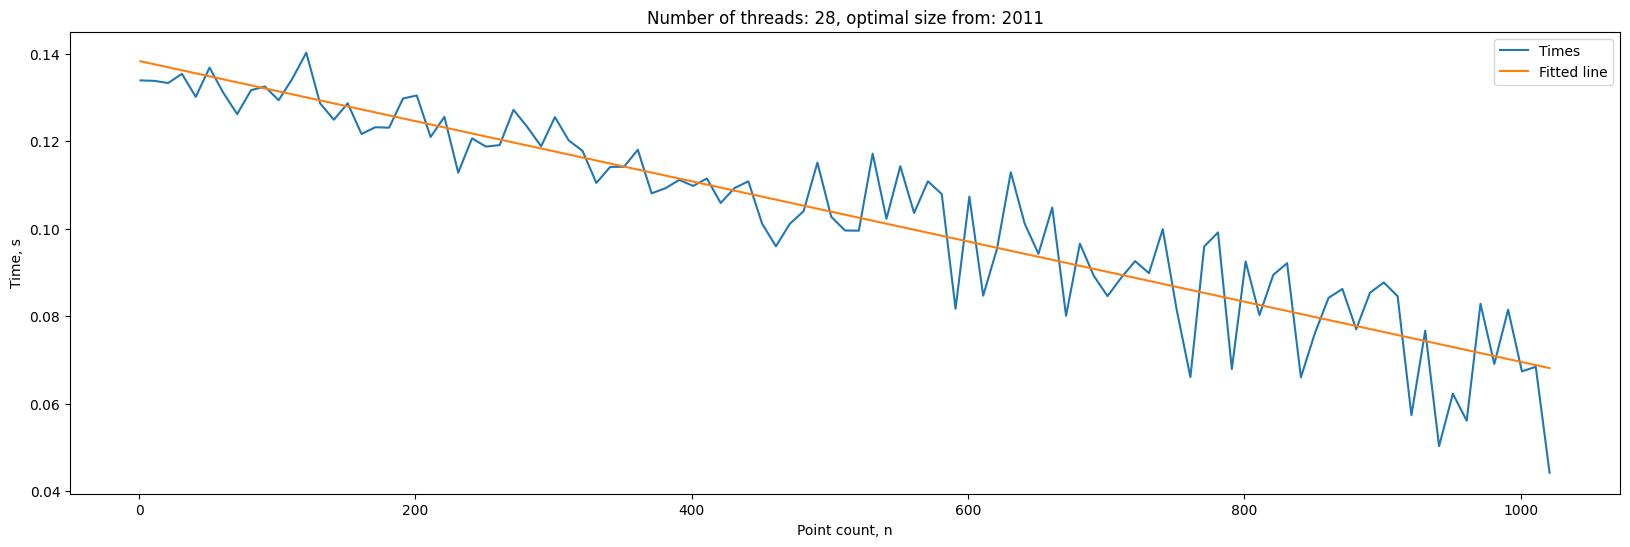

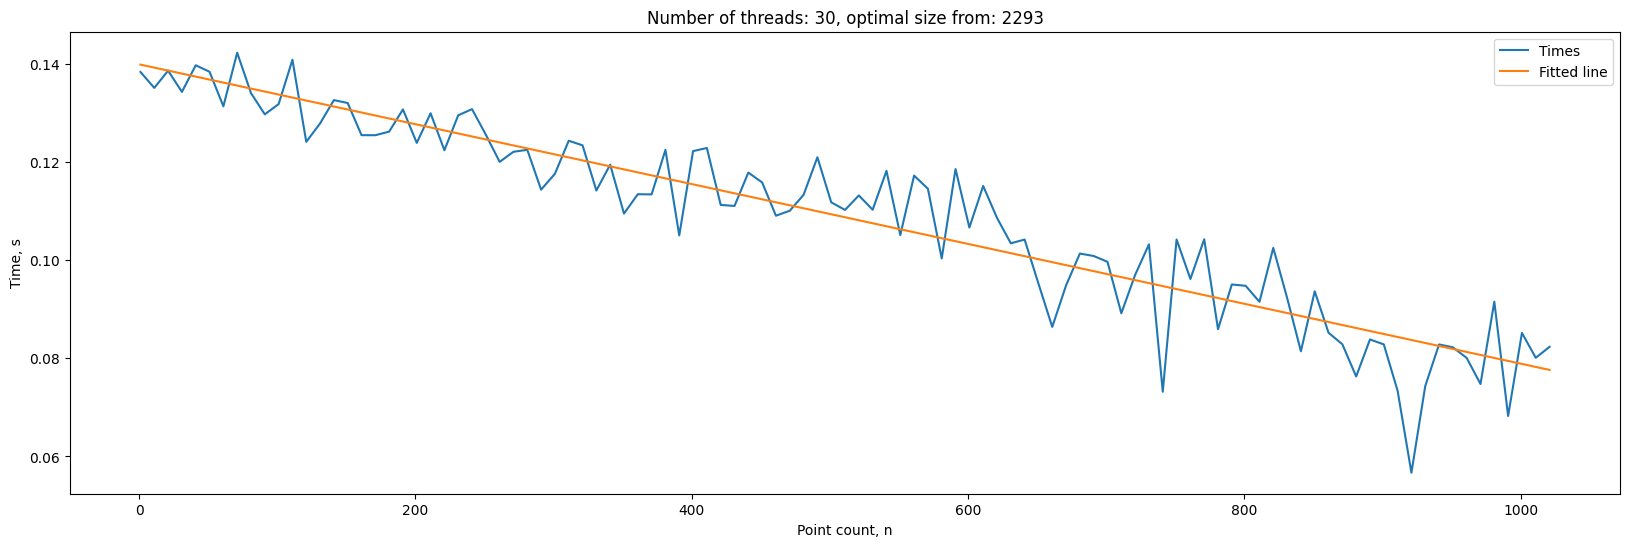

In [11]:
start = 1
finish = 1024
step_size = 10

points_per_thread = []

for i in np.arange(2, 32, 2).tolist():

    basic_times = basic_time_measurement(start, finish, i, step_size)
    points_per_thread.append({"points_per_thread": plot_with_average(start, finish, basic_times, step_size), "threads": i})

In [12]:
points_per_thread

[{'points_per_thread': 286.0597855103466, 'threads': 2},
 {'points_per_thread': 114.94701042636241, 'threads': 4},
 {'points_per_thread': 82.90961828250606, 'threads': 6},
 {'points_per_thread': 70.48166281395173, 'threads': 8},
 {'points_per_thread': 62.521881761230155, 'threads': 10},
 {'points_per_thread': 59.84125276818255, 'threads': 12},
 {'points_per_thread': 63.091557464311656, 'threads': 14},
 {'points_per_thread': 64.8982402732486, 'threads': 16},
 {'points_per_thread': 66.0132140818301, 'threads': 18},
 {'points_per_thread': 66.9363465767212, 'threads': 20},
 {'points_per_thread': 70.9827949577762, 'threads': 22},
 {'points_per_thread': 72.92287740197203, 'threads': 24},
 {'points_per_thread': 72.29013360005807, 'threads': 26},
 {'points_per_thread': 71.82859943890726, 'threads': 28},
 {'points_per_thread': 76.45361351364613, 'threads': 30}]

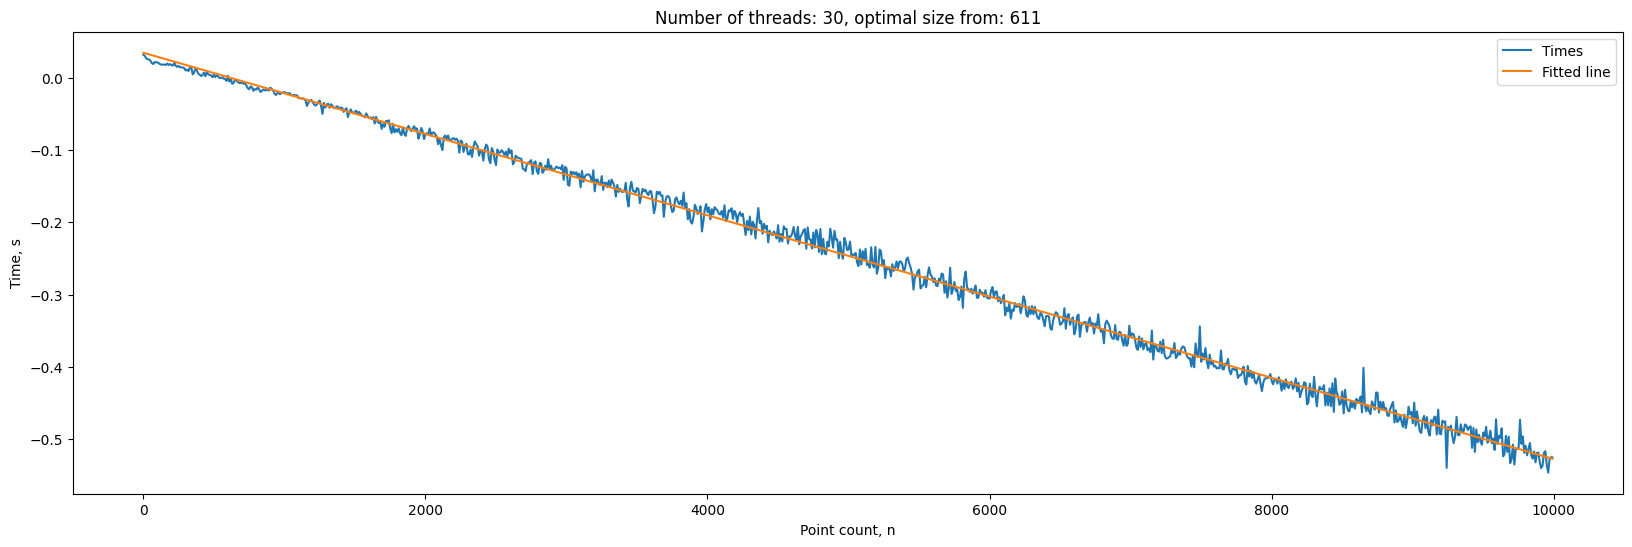

20.383102672351036

In [13]:
optimal_measure = basic_time_measurement(1, 10000, 4, 10)
plot_with_average(1, 10000, optimal_measure, 10)